In [1]:
#!pip install openpyxl

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import perceval as pcvl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from merlin import LexGrouping, QuantumLayer, MeasurementStrategy, ComputationSpace
from merlin.builder import CircuitBuilder
import perceval as pcvl

import pandas as pd
import os

In [3]:
DATA_PATH = "./train.xlsx"

# Loading data

In [4]:
# Load training data (day-first dates)
df = pd.read_excel(DATA_PATH)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)

# Keep Date as first column
df = df[['Date'] + [c for c in df.columns if c != 'Date']]
feature_cols = [c for c in df.columns if c != 'Date']

print(f"Rows: {len(df)}")
print(f"Date range: {df['Date'].min().date()} → {df['Date'].max().date()}")
print(f"Number of surface points: {len(feature_cols)}")

df.head()

Rows: 494
Date range: 2050-01-01 → 2051-12-23
Number of surface points: 224


,Date,Tenor : 1; Maturity : 0.0833333333333333,Tenor : 2; Maturity : 0.0833333333333333,Tenor : 3; Maturity : 0.0833333333333333,Tenor : 4; Maturity : 0.0833333333333333,Tenor : 5; Maturity : 0.0833333333333333,Tenor : 6; Maturity : 0.0833333333333333,Tenor : 7; Maturity : 0.0833333333333333,Tenor : 8; Maturity : 0.0833333333333333,Tenor : 9; Maturity : 0.0833333333333333,...,Tenor : 5; Maturity : 30,Tenor : 6; Maturity : 30,Tenor : 7; Maturity : 30,Tenor : 8; Maturity : 30,Tenor : 9; Maturity : 30,Tenor : 10; Maturity : 30,Tenor : 15; Maturity : 30,Tenor : 20; Maturity : 30,Tenor : 25; Maturity : 30,Tenor : 30; Maturity : 30
0,2050-01-01,0.028565,0.038700,0.040127,0.040762,0.040466,0.038953,0.037553,0.036768,0.036646,...,0.331053,0.329056,0.330997,0.324676,0.325758,0.322393,0.345859,0.359162,0.346670,0.337670
1,2050-01-02,0.029334,0.039499,0.040982,0.041638,0.041336,0.039815,0.038397,0.037631,0.037504,...,0.336319,0.334434,0.336568,0.330244,0.331462,0.328144,0.351816,0.365197,0.350993,0.340822
2,2050-01-03,0.028696,0.038816,0.040328,0.041042,0.040804,0.039329,0.037968,0.037216,0.037107,...,0.333634,0.331707,0.333800,0.327487,0.328710,0.325436,0.348915,0.362236,0.348652,0.339027
3,2050-01-05,0.030854,0.041536,0.043035,0.043605,0.043241,0.041556,0.039977,0.039167,0.038968,...,0.336884,0.335106,0.337548,0.331279,0.332811,0.329771,0.353246,0.366100,0.351404,0.340465
4,2050-01-06,0.030406,0.041174,0.042681,0.043266,0.042937,0.041253,0.039685,0.038867,0.038667,...,0.333249,0.331426,0.333830,0.327580,0.329123,0.326146,0.349390,0.362048,0.348331,0.338022


In [5]:
class FinanceDataset(torch.utils.data.Dataset):
    """PyTorch Dataset for swaption volatility data."""
    
    def __init__(self, X, history):
        self.X = torch.FloatTensor(X.values if isinstance(X, pd.DataFrame) else X)
        self.history = history
    
    def __len__(self):
        return len(self.X) - self.history - 3
    
    def __getitem__(self, idx):
        return self.X[idx:idx+self.history], self.X[idx+self.history+1:idx+self.history+4]

In [6]:
# Build a simple PyTorch Dataset using the next-day target
history=6

X = df[feature_cols].copy()
y = df[feature_cols].shift(-1)

# drop last row where target is NaN
mask = ~y.isnull().any(axis=1)
X = X[mask].reset_index(drop=True)
y = y[mask].reset_index(drop=True)

dataset = FinanceDataset(X, history)
print(f"Dataset size: {len(dataset)} samples")
print(f"Feature dim: {X.shape[1]}, Target dim: {y.shape[1]}")

input_dim = X.shape[1]
target_dim = y.shape[1] * 3
dataset[0]

Dataset size: 484 samples
Feature dim: 224, Target dim: 224


(tensor([[0.0286, 0.0387, 0.0401,  ..., 0.3592, 0.3467, 0.3377],
         [0.0293, 0.0395, 0.0410,  ..., 0.3652, 0.3510, 0.3408],
         [0.0287, 0.0388, 0.0403,  ..., 0.3622, 0.3487, 0.3390],
         [0.0309, 0.0415, 0.0430,  ..., 0.3661, 0.3514, 0.3405],
         [0.0304, 0.0412, 0.0427,  ..., 0.3620, 0.3483, 0.3380],
         [0.0301, 0.0402, 0.0418,  ..., 0.3743, 0.3572, 0.3453]]),
 tensor([[0.0297, 0.0395, 0.0409, 0.0416, 0.0413, 0.0399, 0.0385, 0.0378, 0.0377,
          0.0367, 0.0351, 0.0338, 0.0336, 0.0340, 0.0595, 0.0709, 0.0721, 0.0711,
          0.0713, 0.0677, 0.0677, 0.0663, 0.0652, 0.0643, 0.0605, 0.0579, 0.0575,
          0.0588, 0.0958, 0.1054, 0.1026, 0.1017, 0.1005, 0.0987, 0.0943, 0.0924,
          0.0921, 0.0886, 0.0839, 0.0813, 0.0832, 0.0835, 0.1277, 0.1292, 0.1268,
          0.1255, 0.1225, 0.1166, 0.1162, 0.1144, 0.1124, 0.1084, 0.1029, 0.1007,
          0.0994, 0.1019, 0.1546, 0.1508, 0.1470, 0.1403, 0.1399, 0.1326, 0.1310,
          0.1280, 0.1256, 0.1262, 

In [7]:
from torch.utils.data import random_split, DataLoader

trainset, testset = random_split(dataset, [0.8, 0.2])

trainloader = DataLoader(trainset, batch_size=10, shuffle=True)
testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

In [8]:
# Parsing helpers
def parse_surface_metadata(df):
    tenors, maturities = [], []
    mapping = {}
    for col in df.columns:
        if col == 'Date':
            continue
        parts = col.split(';')
        tenor = float(parts[0].split(':')[1].strip())
        maturity = float(parts[1].split(':')[1].strip())
        tenors.append(tenor)
        maturities.append(maturity)
        mapping[col] = (tenor, maturity)
    return sorted(set(tenors)), sorted(set(maturities)), mapping

def surface_for_date(df, idx, unique_tenors, unique_maturities, mapping):
    row = df.iloc[idx]
    surface = np.full((len(unique_tenors), len(unique_maturities)), np.nan)
    for col, (t, m) in mapping.items():
        t_idx = unique_tenors.index(t)
        m_idx = unique_maturities.index(m)
        surface[t_idx, m_idx] = row[col]
    return surface

unique_tenors, unique_maturities, tm_map = parse_surface_metadata(df)
print(f"Tenors: {len(unique_tenors)} | Maturities: {len(unique_maturities)}")

Tenors: 14 | Maturities: 16


# Testing

In [21]:
def test(model, loader, device="cpu", tolerance=0.10, silent=True):
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        inputs, targets_unflat = next(iter(loader))
        targets = torch.flatten(targets_unflat, start_dim=1)
        outputs = model(inputs)
        print("out shape", outputs.shape)

        sum_residual = torch.nn.functional.mse_loss(outputs, targets, reduction='sum').item()
        
        expectancy = torch.mean(targets)
        sum_square = torch.nn.functional.mse_loss(expectancy, targets, reduction='sum').item()  # Basically variance
        
        r_squared = 1 - sum_residual/sum_square
        
        mse = torch.nn.functional.mse_loss(outputs, targets, reduction='mean').item()
        root_mse = mse**.5
        mae = torch.nn.functional.mse_loss(outputs, targets, reduction='mean').item()
        
    if not silent:
        print(f"Test Results:")
        print("\t", f"MSE: {mse:.4f}")
        print("\t", f"Root MSE: {root_mse:.4f}")
        print("\t", f"MAE: {mae:.4f}")
        print("\t", f"R^2 (coefficient of determination): {r_squared:.4f}")
    
    return mse, root_mse, mae, r_squared

In [10]:
def example(model, loader):
    model.eval()
    
    with torch.no_grad():
        inputs, targets = next(iter(loader))
        outputs = model(inputs)
        
        relative_error = torch.abs(outputs - targets) / (torch.abs(targets) + 1e-7)
            
        print(f'Target={targets}, Output={outputs}, Rel_error={relative_error}')

# Training pipeline

In [11]:
def train(model, loss_fn, optim, n_epochs=10, device='cpu'):
    model.train()
    model.to(device)
    l = []

    pbar = tqdm(range(n_epochs))
    
    for i in pbar:
        cur_loss = 0
        cur_samples = 0
        
        for input, target in trainloader:
            input = input.to(device)
            target = torch.flatten(target.to(device), start_dim=1)
            
            output = model(input)
    
            optim.zero_grad()
            loss = loss_fn(output, target)
            loss.backward()
            optim.step()
            
            cur_loss += loss.sum().cpu().item()
            cur_samples += input.shape[0]
            pbar.set_postfix(loss=cur_loss / cur_samples)
    
        #cur_loss /= len(trainloader)
        #pbar.set_postfix(prev_loss = cur_loss / cur_samples)

# The model

In [39]:
#Classical MLP
def classical_model(param=1000):
    """
    Return a model and its actual number of
    parameters (proportional to `param`)
    """
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_dim*history, param),
        nn.ReLU(),
        nn.Linear(param, target_dim)
    )
    return model, sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Classical MLP size={sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Classical MLP size=201700672


Hybrid quantum model size=201700672


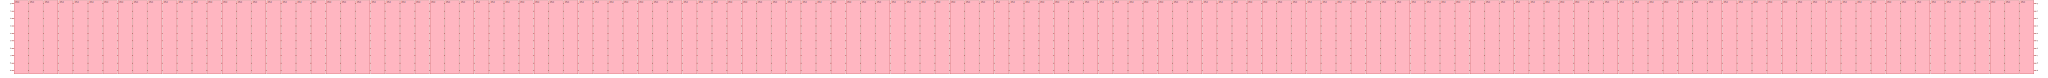

In [40]:
#Hybrid quantum model impl. with MerLin
def create_block(modes, step, max_param, univ_len):
    cir = pcvl.Circuit(modes)

    for i in range(modes):
        if i+step*modes >= max_param:
            break

        cir.add(i, pcvl.PS(pcvl.P(f'input{i+step*modes}')))

    rl = pcvl.GenericInterferometer(
        modes,
        lambda i: pcvl.BS()
        // pcvl.PS(pcvl.P(f"theta_ri{i+univ_len*step}"))
        // pcvl.BS()
        // pcvl.PS(pcvl.P(f"theta_ro{i+univ_len*step}")),
        shape=pcvl.InterferometerShape.RECTANGLE,
    )
    cir.add(0, rl)

    return cir
    

modes = 10
# left generic interferometer
wl = pcvl.GenericInterferometer(
    modes,
    lambda i: pcvl.BS()
    // pcvl.PS(pcvl.P(f"theta_li{i}"))
    // pcvl.BS()
    // pcvl.PS(pcvl.P(f"theta_lo{i}")),
    shape=pcvl.InterferometerShape.RECTANGLE,
)

circuit = pcvl.Circuit(modes)
circuit.add(0,wl)
for i in range(0, input_dim * history, modes):
    step = i // modes
    circuit.add(0, create_block(modes, step, input_dim * history, len(wl.params)))

quantum_layer = QuantumLayer(
    input_size=input_dim*history,
    circuit=circuit,
    n_photons=3,
    trainable_parameters=["theta"],
    input_parameters=["input"],
    dtype=dataset.X.dtype,
)

def classical_model(param=1000):
    model = nn.Sequential(
        nn.Flatten(),
        quantum_layer,
        LexGrouping(quantum_layer.output_size, 3*param),
        nn.Linear(3*param, target_dim)
    )
    return model, sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Hybrid quantum model size={sum(p.numel() for p in model.parameters() if p.requires_grad)}')
pcvl.pdisplay(circuit)

# Playground

In [14]:
from torch.optim import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 1e-3
loss_fn = nn.MSELoss()
optim = Adam(model.parameters(), lr=lr)

train(model, loss_fn, optim, device=device, n_epochs=100)

  0%|                                                                                                                                                                                                   | 0/100 [01:43<?, ?it/s, loss=0.00585]


KeyboardInterrupt: 

In [15]:
torch.save(model.state_dict(), 'weights/classical_model_hist6.pth')

In [16]:
example(model, testloader)

KeyboardInterrupt: 

In [26]:
test(model, testloader, silent=False)

out shape torch.Size([96, 672])
Test Results:
	 MSE: 0.0632
	 Root MSE: 0.2514
	 MAE: 0.0632
	 R^2 (coefficient of determination): -5.3704


/tmp/ipykernel_52642/3430668776.py:19: UserWarning: Using a target size (torch.Size([96, 672])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  sum_square = torch.nn.functional.mse_loss(expectancy, targets, reduction='sum').item()  # Basically variance


(0.06320846080780029,
 0.2514129288795632,
 0.06320846080780029,
 -5.370388748604761)

In [ ]:
#WiP

def predict(df, model):
    complete_df = df[df['Type'] == 'Complete '].copy()
    missing_df = df[df['Type'] == 'Missing Data'].copy()
    incomplete_df = df[df['Type'] == 'Future Prediction'].copy()

    complete_data = completed_df.drop(columns=['Type', 'Date']).values
    t_complete = torch.tensor(completed_data, dtype=torch.float32)

    print(t_completed.shape)
    
    
    #model.test()


samples = pd.read_excel('sample_Simulated_Swaption_Price.xlsx')
predict(samples, None)

samples.head()

In [42]:
from typing import NamedTuple

class StatResults(NamedTuple):
    mse: float
    root_mse: float
    mae: float
    r_squared: float

results = []
for param in [10, 100, 1000, 5000]:
    model, actual_params = classical_model(param)
    result = StatResults(test(model, testloader))
    results.append(*result)

out shape torch.Size([96, 672])


/tmp/ipykernel_52642/3430668776.py:19: UserWarning: Using a target size (torch.Size([96, 672])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  sum_square = torch.nn.functional.mse_loss(expectancy, targets, reduction='sum').item()  # Basically variance


TypeError: StatResults.__new__() missing 3 required positional arguments: 'root_mse', 'mae', and 'r_squared'